In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df          = pd.read_parquet('/Users/williamsoma/Library/CloudStorage/OneDrive-NTNU/Portfolio optimization/OSEBX_data.parquet')
df['Date']  = pd.to_datetime(df['Date'])
cols        = ['Date', 'Close', 'ISIN']
df          = df[cols]
df['ISIN']  = df['ISIN'].astype('category')
#df          = pd.concat([df, pd.get_dummies(df['ISIN'])], axis=1)
df['Close'] = df.groupby('ISIN')['Close'].fillna('ffill').pct_change()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643743 entries, 0 to 1643742
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1643743 non-null  datetime64[ns]
 1   Close   1643742 non-null  float64       
 2   ISIN    1643743 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 28.3 MB


In [3]:
isin_pca = PCA(5)
T = isin_pca.fit_transform(pd.get_dummies(df['ISIN']))
T

array([[-0.01497747, -0.0067499 , -0.00926342, -0.00473968, -0.01067387],
       [-0.01497747, -0.0067499 , -0.00926342, -0.00473968, -0.01067387],
       [-0.01497747, -0.0067499 , -0.00926342, -0.00473968, -0.01067388],
       ...,
       [-0.0149311 , -0.00671792, -0.00921758, -0.00471302, -0.01061396],
       [-0.0149311 , -0.00671792, -0.00921758, -0.00471302, -0.01061396],
       [-0.0149311 , -0.00671792, -0.00921758, -0.00471302, -0.01061396]])

In [4]:
df = pd.concat([df, pd.DataFrame(T)], axis=1)

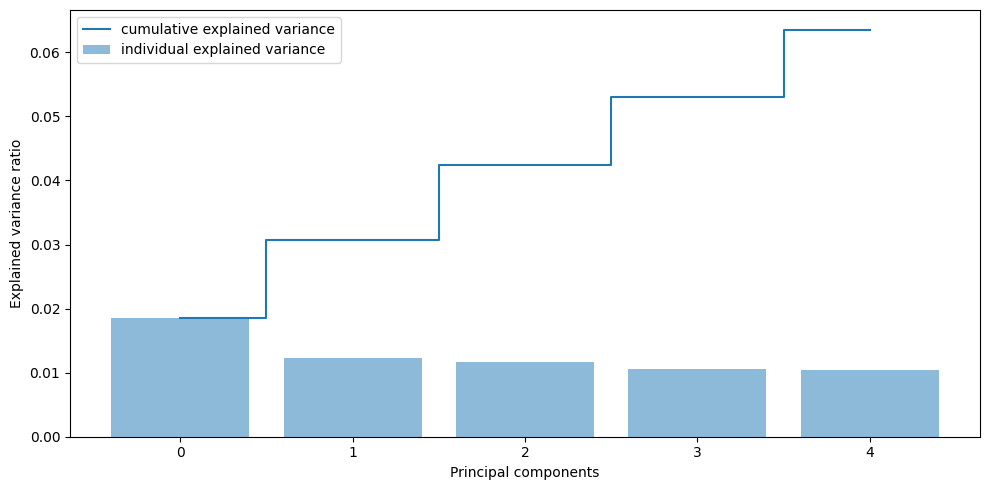

In [5]:
# Calculate explained variance ratios
explained_variance_ratio = isin_pca.explained_variance_ratio_

# Create explained variance plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(explained_variance_ratio)), np.cumsum(explained_variance_ratio), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
df['var']    = df['Close']**2
df['y']      = df.groupby('ISIN')['var'].shift(-1)
df['var_l1'] = df.groupby('ISIN')['var'].shift(1)
df['var_l2'] = df.groupby('ISIN')['var'].shift(2)
df['var_l3'] = df.groupby('ISIN')['var'].shift(3)
df['var_l4'] = df.groupby('ISIN')['var'].shift(4)


var_scaler = StandardScaler()
df[['y','var' , 'var_l1', 'var_l2', 'var_l3', 'var_l4']] = pd.DataFrame(var_scaler.fit_transform(df[['y','var' , 'var_l1', 'var_l2', 'var_l3', 'var_l4']]), columns=['y','var' , 'var_l1', 'var_l2', 'var_l3', 'var_l4'])
df = df.dropna()

y  = df[['Date', 'y']]
X  = df.drop(['y', 'ISIN', 'Close'], axis=1)

split_date = '2018-01-01'

y_train = y.loc[y['Date'] >= split_date, 'y']
y_test  = y.loc[y['Date'] < split_date, 'y']

x_train = X.loc[y['Date'] >= split_date].drop('Date', axis=1)
x_test  = X.loc[y['Date'] < split_date].drop('Date', axis=1)

In [7]:
x_train.shape, y_train.shape

((175787, 10), (175787,))

In [8]:
x_train.shape, y_train.shape
x_test.shape, y_test.shape

((1463600, 10), (1463600,))

# XGB model

[0]	validation_0-rmse:0.35309	validation_1-rmse:1.11553
[10]	validation_0-rmse:0.01644	validation_1-rmse:1.06120
[16]	validation_0-rmse:0.00603	validation_1-rmse:1.06168


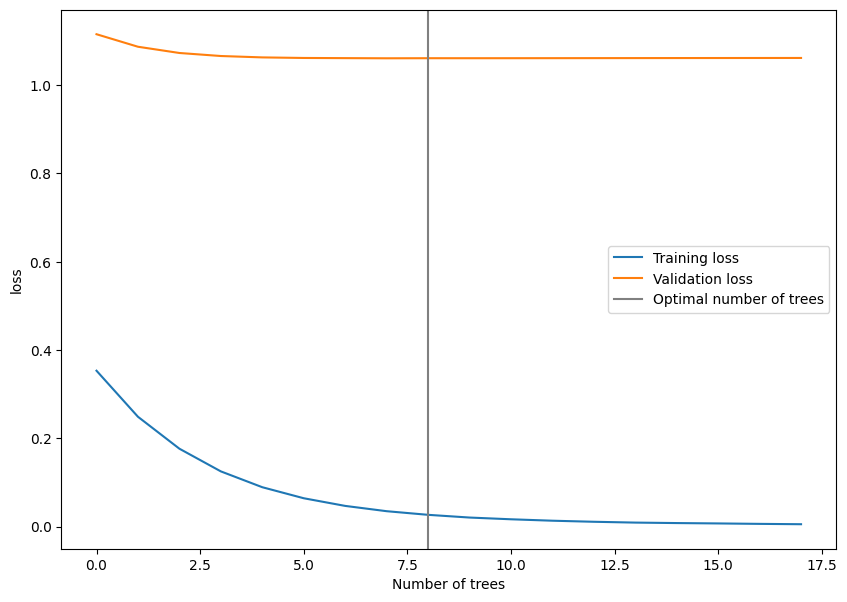

In [9]:
model = xgb.XGBRegressor(n_estimators=200,
                         early_stopping_rounds=10,
                         )
model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose=10
          )
result = model.evals_result()
plt.figure(figsize=(10,7))
plt.style.use("default")
plt.plot(result['validation_0']['rmse'], label='Training loss')
plt.plot(result['validation_1']['rmse'], label='Validation loss')
plt.axvline(model.best_ntree_limit, color='grey', label='Optimal number of trees')
plt.xlabel('Number of trees')
plt.ylabel('loss')
plt.legend()
plt.show()

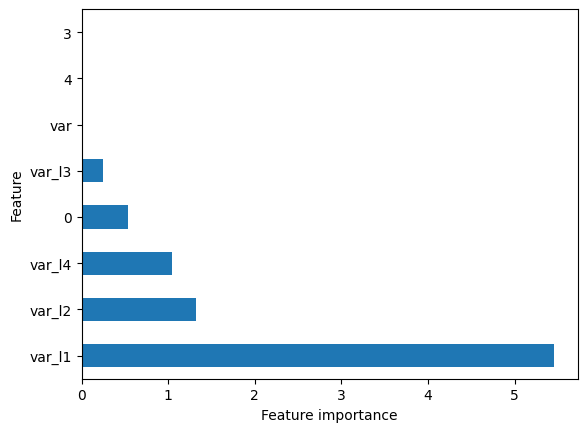

In [10]:
booster = model.get_booster()
weight = list(booster.get_score(importance_type='weight').values())
gain = list(booster.get_score(importance_type='gain').values())
cover =list(booster.get_score(importance_type='cover').values())
columns = list(booster.get_score(importance_type='weight').keys())
feature_importance = pd.DataFrame(np.array([weight, gain, cover]), columns=columns, index=['weight', 'gain', 'cover']).T
feature_importance.sort_values(by='gain', ascending=False)['gain'].iloc[:26].plot(kind='barh', xlabel='Feature importance', ylabel='Feature')
plt.show()

In [11]:
score = model.score(x_test, y_test)  
print("Training score: ", score)


Training score:  -0.0030547828709721614
